# ARTChat: Re-prescription App for HIV/ART Prescriptions

**Manan Kocher, PhD | manan.kocher@gmail.com | Insight Health Data Science Fellow**

ARTChat is an anti-retroviral therapy prescription recommendation app developed by Manan Kocher as part of a 3 week Insight Data Science Fellowship project. The three main goals of this app are to (1) streamline prescription practices to save physicians time, (2) prioritize patient safety by providing data driven recommendations, and (3) improve patient education in their own treatment through an interactive interface. <br/>

The code written out in this notebook serves as the backbone of the recommender framework. A variety of different techniques are used in creative ways to develop the app within the time constraint. If you have any questions, please do not hestitate to reach out to me at manan.kocher@gmail.com

A presentation of the project can be found at: http://bit.ly/artchat_hiv <br/>
The app can be accessed at: www.manankocher.com (built using Dash)

In [1]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expression module
%matplotlib inline

import xml.etree.ElementTree as ET #XML reading and manipulation
import sqlite3 

from urllib.request import urlopen
from bs4 import BeautifulSoup #Beautiful soup object is used to parse the html page into python objects
import requests

import re #regular expression
import heapq #used in rank matrix

#Unsupervised learning:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import copy
import pickle

### FDA-approved list of HIV/ART drugs
Importing data manually since this is more efficient and allows me to get intimately familiar with the names. 

In [3]:
#Importing the latest approved HIV/ART drugs with Brand Name, Generic Name/Ingredients

drugs_art = pd.DataFrame(
    columns=['Brand_Names', 'Generic_Name/Other_Names', 'Drug_Class'])

drugs_art['Brand_Names'] = [
    'Ziagen', 'Emtriva', 'Epivir', 'Viread', 'Retrovir', 'Pifeltro', 'Sustiva',
    'Intelence', 'Viramune', 'Viramune XR', 'Edurant', 'Reyataz', 'Prezista',
    'Lexiva', 'Norvir', 'Invirase', 'Aptivus', 'Fuzeon', 'Selzentry',
    'Tivicay', 'Isentress', 'Isentress HD', 'Trogarzo', 'Tybost', 'Epzicom',
    'Triumeq', 'Trizivir', 'Evotaz', 'Biktarvy', 'Prezcobix', 'Symtuza',
    'Dovato', 'Juluca', 'Delstrigo', 'Atripla', 'Symfi', 'Symfi Lo', 'Genvoya',
    'Stribild', 'Odefsey', 'Complera', 'Descovy', 'Truvada', 'Cimduo',
    'Combivir', 'Kaletra'
]

drugs_art['Generic_Name/Other_Names'] = [
    ['abacavir'], ['emtricitabine'],
    ['lamivudine'],
    ['tenofovir'],
    ['zidovudine'], ['doravine'],
    ['efavirenz'], ['etravirine'], ['nevirapine'], ['nevirapine'], ['rilpivirine'],
    ['atazanavir'],
    ['darunavir'],
    ['fosamprenavir'],
    ['ritonavir'], ['saquinavir'],
    ['tipranavir'], ['enfuvirtide'], ['maraviroc'],
    ['dolutegravir'],
    ['raltegravir'],
    ['raltegravir'],
    ['ibalizumab-uiyk'],
    ['cobicistat'], ['abacavir', 'lamivudine'],
    ['abacavir','dolutegravir', 'lamivudine'],
    ['abacavir', 'lamivudine', 'zidovudine'], ['atazanavir', 'cobicistat'],
    ['bictegravir', 'emtricitabine', 'tenofovir'],
    ['darunavir', 'cobicistat'],
    ['darunavir', 'cobicistat', 'emtricitabine', 'tenofovir'],
    ['dolutegravir', 'lamivudine'], ['dolutegravir', 'rilpivirine'],
    ['doravirine', 'lamivudine', 'tenofovir'],
    ['efavirenz', 'emtricitabine', 'tenofovir'],
    ['efavirenz', 'lamivudine', 'tenofovir'],
    ['efavirenz', 'lamivudine', 'tenofovir'],
    ['elvitegravir', 'cobicistat', 'emtricitabine', 'tenofovir'],
    [
        'elvitegravir', 'cobicistat', 'emtricitabine',
        'tenofovir'
    ], ['emtricitabine', 'rilpivirine', 'tenofovir'],
    ['emtricitabine', 'rilpivirine', 'tenofovir'],
    ['emtricitabine', 'tenofovir'],
    ['emtricitabine', 'tenofovir'],
    ['lamivudine', 'tenofovir'],
    ['lamivudine', 'zidovudine'], ['lopinavir', 'ritonavir']
]

drugs_art['Drug_Class'] = [
    'NRTI', 'NRTI', 'NRTI', 'NRTI', 'NRTI', 'NNRTI', 'NNRTI', 'NNRTI', 'NNRTI',
    'NNRTI', 'NNRTI', 'PI', 'PI', 'PI', 'PI', 'PI', 'PI', 'FI', 'CCR5', 'INSTI',
    'INSTI', 'INSTI', 'PAI', 'PE', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb',
    'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb',
    'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb', 'Comb'
]

export_csv = drugs_art.to_csv(r'/Users/mkocher/Desktop/ARTChat/HIV_ART.csv',index = None, header=True)
drugs_art.to_pickle('/Users/mkocher/Desktop/ARTChat/pickled_data/drugs_art.pkl')
drugs_art.head()

,Brand_Names,Generic_Name/Other_Names,Drug_Class
0,Ziagen,[abacavir],NRTI
1,Emtriva,[emtricitabine],NRTI
2,Epivir,[lamivudine],NRTI
3,Viread,[tenofovir],NRTI
4,Retrovir,[zidovudine],NRTI


### Data visualization of the breadth of HIV/ART drugs that make up combination therapies

Comb     22
PI        6
NNRTI     6
NRTI      5
INSTI     3
CCR5      1
PAI       1
PE        1
FI        1
Name: Drug_Class, dtype: int64


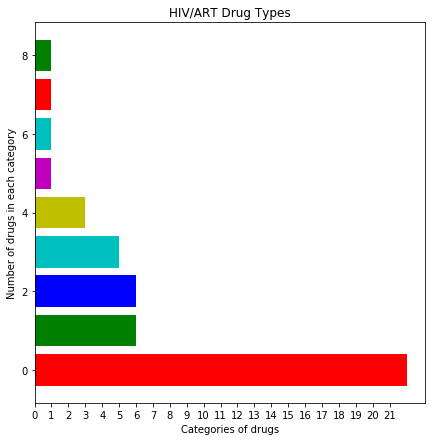

In [4]:
#Histograms of different drug classes
class_count = drugs_art['Drug_Class'].value_counts()
my_colors = 'rgbcymc'
print(class_count)

plt.figure(figsize = (7,7))
plt.barh(np.arange(len(class_count.index)),class_count,color=my_colors)
plt.style.use('dark_background')
plt.xlabel('Categories of drugs')
plt.ylabel('Number of drugs in each category')
plt.title('HIV/ART Drug Types')
plt.savefig('/Users/mkocher/Desktop/ARTChat/figures_week2/ARTDrugs.png')
plt.xticks(np.arange(0,22,1))
plt.show()

> We have 22 combination drugs & 24 individual drugs. Drugs are administered typically as 2 NRTIs + 1 II/PI [Dr. Shihadeh]

### Drug Side-Effect Databases : Importing, Joining, and Wrangling

In [6]:
#Importing tsv files of drugs and side-effects

#The following file contains the drug names + their IDs
drugs_id = pd.read_csv('drug_names.tsv',
                       sep='\t',
                       header=None,
                       error_bad_lines=False)

#The following file contains drug names and their corresponding side-effects
sideeffects = pd.read_csv(
    'meddra_freq.tsv',
    sep='\t',
    header=None)

#Cleaning up side-effect dataset
#print(drugs_id.head())  #quick view
print(sideeffects.shape)  #quick view
sideeffects.columns = [
    'CID', 'Code2', 'Code3', 'IsPlacebo', 'Freq_desc', 'freq_low', 'freq_high',
    'Labels', 'Code4', 'SideEffects'
]  #labeling columns

sideeffects = sideeffects.drop(['Code2', 'Code3', 'Code4', 'IsPlacebo'],
                               axis=1)  #dropping axes from table we don't need

#Dropping data that is uncommon, rare, postmarketing, infrequent and has a % of less than 25 and LLT
drop_rows = sideeffects.index[(sideeffects['Labels'] == 'LLT') |
                             (sideeffects['Freq_desc'] == 'postmarketing') |
                             (sideeffects['Freq_desc'] == 'rare') | (sideeffects['Freq_desc'] == 'infrequent') | (sideeffects['Freq_desc'] == 'uncommon') | (sideeffects['Freq_desc'] == 'very rare') ].tolist(
                             )  #dropping rows that have LLT (only keep PT)

sideeffects = sideeffects.drop(sideeffects.index[drop_rows])

sideeffects.reset_index(inplace=True)  #reset index after row drop

sideeffects = sideeffects.drop('Labels', axis=1)  #Since the whole team is PT

#cleaning up drugs_id dataset
drugs_id.columns = ['CID', 'Drug']

sideeffects = sideeffects.set_index('CID').join(
    drugs_id.set_index('CID'))  #combining both datasets


#create new indices of integers
sideeffects = sideeffects.reset_index()
sideeffects['Freq_desc']=pd.to_numeric(sideeffects['Freq_desc'],errors='coerc') #converting str->float, NaNs for messy values (e.g. 1-3)
sideeffects['Freq_desc']=sideeffects['Freq_desc'].fillna(0) 
sideeffects = sideeffects.drop('index',axis=1) #dropping the column named 'index'

sideeffects.head()

b'Skipping line 1075: expected 2 fields, saw 3\n'


(291632, 10)


,CID,Freq_desc,freq_low,freq_high,SideEffects,Drug
0,CID100000085,21.0,0.21,0.21,Abdominal pain,carnitine
1,CID100000085,21.0,0.21,0.21,Gastrointestinal pain,carnitine
2,CID100000085,5.0,0.05,0.05,Abdominal pain,carnitine
3,CID100000085,5.0,0.05,0.05,Gastrointestinal pain,carnitine
4,CID100000085,6.0,0.06,0.06,Abdominal pain,carnitine


### Side-effects data at a glance 

/Users/mkocher/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


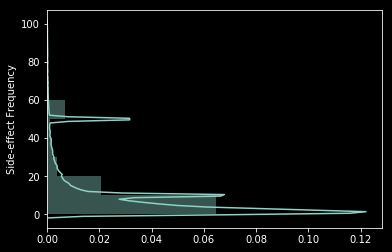

The list has 2131 unique sideeffects
Total number of drugs in the list are 872


In [8]:
#This does not contain frequencies less than a 25% - gotta reverse that.
plt.figure()
sns.distplot(sideeffects['Freq_desc'],bins=10,axlabel='Side-effect Frequency',vertical=True,norm_hist=True)
plt.show()

#How many unique side-effects are there in the table?
print('The list has '+str(sideeffects['SideEffects'].nunique())+' unique sideeffects')
print('Total number of drugs in the list are '+str(sideeffects['Drug'].nunique()))

### Clustering of drugs based on side-effect profiles
       Preparing the data:
       Step 1: Creating the table that contains name of drug as rows and the side-effects as columns 
       Step 2: Reducing the table so it contains only HIV/ART drugs
       Step 3: Clean up the DataFrame. Ready for analysis!

In [9]:
#side-effects [This part of the code takes some time to run]
list1 = drugs_art['Generic_Name/Other_Names'].tolist() #processing out the list of generic drug names
cluster_drug_names = [item for sublist in list1 for item in sublist]   #flattening out the list

master=pd.DataFrame()
for rows in sideeffects.index:
    master.loc[sideeffects['Drug'][rows],sideeffects['SideEffects'][rows]] = sideeffects['Freq_desc'][rows]

master.head() #this list contains all the drugs and their side-effects

,Abdominal pain,Gastrointestinal pain,Amblyopia,Anaemia,Decreased appetite,Anxiety,Arrhythmia,Asthenia,Atrial fibrillation,Back pain,...,Keratosis pilaris,Bowen's disease,Keratoacanthoma,Panniculitis,Papilloma,Acrochordon,Multiple sclerosis,Post-traumatic pain,Traumatic liver injury,Activated partial thromboplastin time prolonged
carnitine,17.0,17.0,2.0,3.0,3.0,5.0,5.0,8.0,6.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5-aminolevulinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
leucovorin,NaN,NaN,NaN,NaN,4.0,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PGE2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prostacyclin,5.0,5.0,NaN,NaN,66.0,9.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2 and 3 of preparation for Clustering

In [11]:
cluster_drug_names = [x.lower() for x in cluster_drug_names
                      ]  #converting all drug names to lowercase
master.index = master.index.str.lower(
)  #converting all indices in the master to lowercase

master.loc[cluster_drug_names[3]]
#reduce cluster_drug_names to an array that is within master.index
reduced_list = master.loc[master.index.isin(cluster_drug_names) == True]
reduced_list = reduced_list.replace(np.nan, 0)  #replacing NaNs with zeros

nunique = reduced_list.apply(
    pd.Series.nunique
)  #dropping all columns with only zeros since those side-effects are irrelevant here
cols_to_drop = nunique[nunique == 1].index
reduced_list = reduced_list.drop(cols_to_drop, axis=1)

reduced_list.to_pickle("/Users/mkocher/Desktop/ARTChat/pickled_data/reduced_list.pkl")
reduced_list.head()

,Abdominal pain,Gastrointestinal pain,Anaemia,Decreased appetite,Anxiety,Asthenia,Back pain,Bronchitis,Chest pain,Infection,...,Lymphocyte count decreased,Hepatic steatosis,Nephritis,Ocular icterus,Hepatitis toxic,Rash vesicular,Anogenital warts,Apocrine and eccrine gland disorders,Urinary tract signs and symptoms,Vascular hypertensive disorders
abacavir,0.0,0.0,0.0,50.0,5.18,50.00,0.0,0.0,0.0,9.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
efavirenz,50.0,50.0,0.0,2.0,50.00,50.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lamivudine,11.0,19.0,10.0,7.0,0.00,3.12,0.0,5.8,0.0,21.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nevirapine,1.0,1.0,10.0,0.0,0.00,4.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ritonavir,5.1,5.1,4.0,4.2,0.90,6.40,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


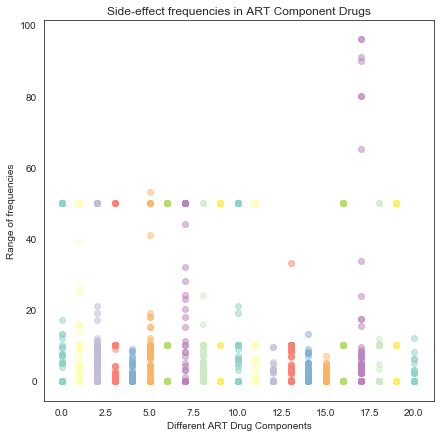

In [30]:
#Plot side-effect frequencies for the ART drugs

plt.figure(figsize=(7, 7))
sns.set_style('white')
data_to_plot = []
for i in np.arange(0, (len(reduced_list.iloc[:, 0]))):  #for each drug
    plt.scatter(np.full((1, len(reduced_list.iloc[0, :])), i),
                reduced_list.iloc[i, :],
                alpha=0.5)  #draw a categorical scatter
    #plot with no overlapping points
plt.xlabel('Different ART Drug Components')
plt.ylabel('Range of frequencies')
plt.title('Side-effect frequencies in ART Component Drugs')
plt.savefig(
    '/Users/mkocher/Desktop/ARTChat/figures_week2/ARTDrug_Frequencies.png')
plt.show()

In [17]:
#Saving the lists of side-effects as a .csv file for the Dash app
import csv

side_effects_dash = reduced_list.columns.tolist()
#export_csv = side_effects_dash.save(r'/Users/mkocher/Desktop/ARTChat/data/side_effects_dash.csv',index = None, header=True)

with open('side_effects_dash.txt', 'w') as f:
    for item in side_effects_dash:
        f.write("%s," % item)

> There are a total of 21 Drugs with 284 Side-effects to consider. <br/> 
> In the FDA drug list there are 24 individual drugs.<br/>
> There are some drugs missing from the list.

abacavir         23.179394
efavirenz        18.941429
lamivudine       12.370000
nevirapine       12.954545
ritonavir         2.414286
zidovudine       12.410769
saquinavir       40.909091
emtricitabine    35.304348
tenofovir         7.514091
fosamprenavir    43.600000
atazanavir       16.434211
tipranavir       17.291429
etravirine        3.949692
darunavir         7.109123
maraviroc         3.302000
rilpivirine       2.614286
elvitegravir     29.047619
enfuvirtide      17.346000
raltegravir      12.585185
cobicistat       39.090909
dolutegravir      4.636364
dtype: float64


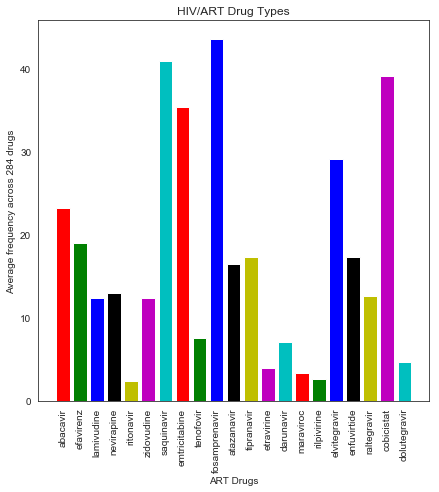

In [25]:
#Side-effect visualization:
mean_value = reduced_list[reduced_list !=0].apply(np.mean,axis=1)
my_colors = 'rgbkymc'
print(mean_value)

plt.figure(figsize = (7,7))
plt.bar(mean_value.index,mean_value,color=my_colors)
plt.xticks(rotation=90)
plt.xlabel('ART Drugs')
plt.ylabel('Average frequency across 284 drugs')
plt.title('HIV/ART Drug Types')
plt.savefig('/Users/mkocher/Desktop/ARTChat/figures_week2/Frequency_sideeffects.png')
plt.show()

### Principal Component Analysis for dimensionality reduction

> First we reduce the number of dimensions from 284 to prepare the data for clustering


In [31]:
stddev = np.std(reduced_list.iloc[:,0])
reduced_list.iloc[:,0]

abacavir          0.0
efavirenz        50.0
lamivudine       11.0
nevirapine        1.0
ritonavir         5.1
zidovudine       50.0
saquinavir       50.0
emtricitabine    50.0
tenofovir         3.0
fosamprenavir    50.0
atazanavir       50.0
tipranavir       50.0
etravirine        3.0
darunavir         8.3
maraviroc         7.7
rilpivirine       2.0
elvitegravir     50.0
enfuvirtide       4.7
raltegravir       0.0
cobicistat       50.0
dolutegravir      0.0
Name: Abdominal pain, dtype: float64

### Scree Plot
> The elbow plot is used to pick number of dimensions to reduce based on variance captured

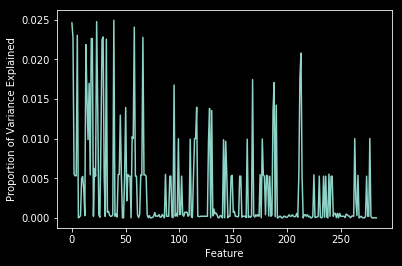

In [128]:
#Picking Number of dimensions to reduce to: scree plot

pr_var = np.zeros(len(reduced_list.columns)) #stddev^2
prop_var = np.zeros(len(reduced_list.columns)) #proportion of variance

for i in np.arange(len(reduced_list.columns)): #going through each principal component
    stddev = np.std(reduced_list.iloc[:,i]) #standard deviation of each principal component
    pr_var_i = stddev**2
    pr_var[i] = pr_var_i #adding the the array

prop_var = pr_var/np.sum(pr_var)

plt.figure()
plt.plot(prop_var)
plt.xlabel("Feature")
plt.ylabel("Proportion of Variance Explained")
#plt.ylim((-1,1))
plt.show()


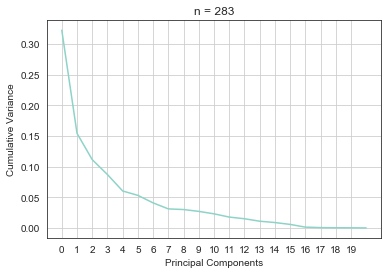

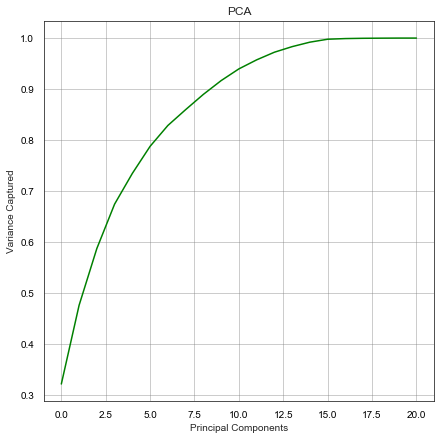

In [427]:
#pca for n = 283
pca = PCA(n_components = 283)
principal_components = pca.fit_transform(reduced_list)
exvar = pca.explained_variance_

cumulative_variance = np.zeros(len(exvar)) #computing cumulative variance
for i in np.arange(len(exvar)):
    cumulative_variance[i] = exvar[i]/np.sum(exvar)
    
plt.figure()
plt.plot(cumulative_variance)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('n = 283')
plt.grid()
plt.xticks(np.arange(0,20,1))
plt.show()

cumsum = np.zeros(len(exvar)) #where does it catch 90% of the variance?
cumsum[0] = cumulative_variance[0]
for i in range(1,len(exvar)):
    cumsum[i] = cumsum[i-1]+cumulative_variance[i]

cumsum

plt.figure(figsize = (7,7))
sns.set_style('white')
plt.plot(cumsum,c='g')
plt.xlabel('Principal Components')
plt.ylabel('Variance Captured')
plt.title('PCA')
plt.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='gray', grid_alpha=0.5)
plt.savefig('/Users/mkocher/Desktop/ARTChat/figures_week2/pca_variance.png')
plt.grid()
plt.show()

**n = 10 captures 90% of the Variance. Dimensions reduced from 283 -> 10**

### Now to find the number of clusters for K-Means clustering

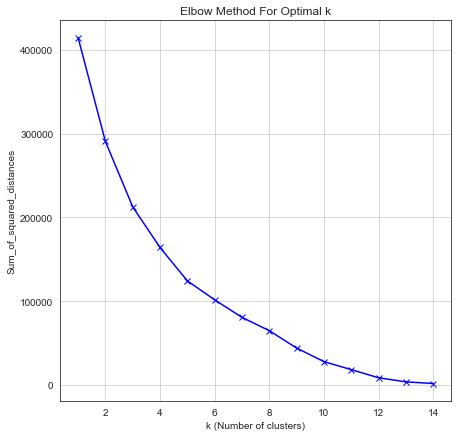

In [33]:
#pca for n = 10
pca = PCA(n_components = 10)
principal_components9 = pca.fit_transform(reduced_list)
principal_df9 = pd.DataFrame(data = principal_components9, columns=['Principal_Component_1','Principal_Component_2','Principal_Component_3','Principal_Component_4','Principal_Component_5','Principal_Component_6','Principal_Component_7','Principal_Component_8','Principal_Component_9','Principal_Component_10'])

Sum_of_squared_distances = []
K = range(1,15)       #why is this range 1 to 15?
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(principal_df9.values)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize = (7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

From the above plot it is difficult to determine what the appropriate number of clusters should be. Attempting the cumulative sum.

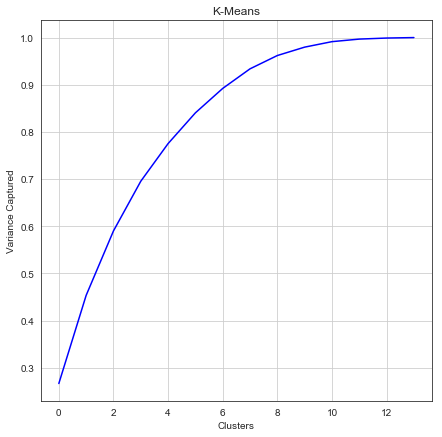

In [34]:
cumsum = np.zeros(len(K)) #where does it catch 90% of the variance?
cumsum[0] = Sum_of_squared_distances[0]/np.sum(Sum_of_squared_distances)
for i in range(1,len(K)):
    cumsum[i] = (cumsum[i-1]+Sum_of_squared_distances[i])/np.sum(Sum_of_squared_distances)
#Not sure if this metric works
variance_captured = np.cumsum(Sum_of_squared_distances)/np.sum(Sum_of_squared_distances)


plt.figure(figsize = (7,7))
plt.grid()
plt.plot(variance_captured,c='b')
plt.xlabel('Clusters')
plt.ylabel('Variance Captured')
plt.title('K-Means')
plt.savefig('/Users/mkocher/Desktop/ARTChat/figures_week2/kmeans_variance.png')
plt.show()

**n = 4 captures >90% of the variance**

### K-Means Clustering

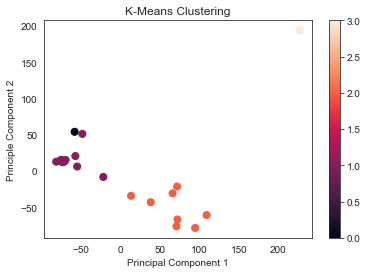

In [35]:
model9 = KMeans(n_clusters=4,n_init=100)
y=model9.fit(principal_df9.values)
clust_labels5 = model9.predict(principal_df9.values)
center5 = model9.cluster_centers_

kmeans5 = pd.DataFrame(clust_labels5)
principal_df9.insert((principal_df9.shape[1]),'kmeans_n_5',kmeans5)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('xkcd:white')
scatter = ax.scatter(principal_df9['Principal_Component_1'],principal_df9['Principal_Component_2'],
                     c=kmeans5[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principle Component 2')
plt.colorbar(scatter)
plt.show()

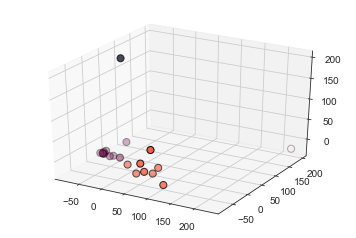

In [36]:
#3Dimensional Scatterplot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(facecolor='white')
#ax.set_facecolor('xkcd:white')
sns.set_style('white')
#fig.patch.set_alpha(0)
#ax.patch.set_alpha(0)
#ax.patch.set_facecolor('white')
#fig.set_facecolor('xkcd:white')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_df9['Principal_Component_1'],principal_df9['Principal_Component_2'],principal_df9['Principal_Component_3'],c=kmeans5[0],edgecolor='k',s=50)
plt.savefig('/Users/mkocher/Desktop/ARTChat/figures_week2/clustering4.png')
plt.show()

In [37]:
principal_df9.to_pickle('/Users/mkocher/Desktop/ARTChat/pickled_data/principal_df9.pkl')

### Ranking how far each cluster is from all other clusters using Eucledian Distance

In [38]:
#computing eucledian distance between centers and ranking the distance between clusters for each cluster:
center5 #contains the coordinates of the centroids of the 4 clusters in 10-dimensional space
distance_metric = sklearn.metrics.pairwise.euclidean_distances(center5)
print(distance_metric)

#for each row, where is the maximum value of distance?
ranks_dist = np.zeros((len(distance_metric),len(distance_metric)))

i=0
while(i<len(distance_metric)):
    temp = distance_metric[i,:].argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(distance_metric[0,:]))
    ranks_dist[i,:] = ranks
    i+=1

ranks_dist = ranks_dist
print(ranks_dist)
with open('/Users/mkocher/Desktop/ARTChat/pickled_data/ranks_dist.pkl','wb') as f: pickle.dump(ranks_dist, f)

[[  0.         230.1778403  260.86322633 393.63661631]
 [230.1778403    0.         150.10000233 343.31237034]
 [260.86322633 150.10000233   0.         296.49284934]
 [393.63661631 343.31237034 296.49284934   0.        ]]
[[0. 1. 2. 3.]
 [2. 0. 1. 3.]
 [2. 1. 0. 3.]
 [3. 2. 1. 0.]]


**Interpreting the above table: For cluster no. 1, Cluster no. 4 is the farthest, then 3 then 2 ...**

In [39]:
#Drugs and what clusters they belong to
cluster_results = pd.DataFrame(columns=['Drug','Cluster_no'])
cluster_results['Drug'] = reduced_list.index
cluster_results['Cluster_no'] = clust_labels5
cluster_results

cluster_results.to_pickle('/Users/mkocher/Desktop/ARTChat/pickled_data/cluster_results.pkl')
cluster_results

#Creating a new dataframe with drugs,cluster_no, and side-effect frequencies
clusters_side_effects = pd.merge(left=reduced_list,right=cluster_results, right_on='Drug',left_on = reduced_list.index)
clusters_side_effects.head()

,Abdominal pain,Gastrointestinal pain,Anaemia,Decreased appetite,Anxiety,Asthenia,Back pain,Bronchitis,Chest pain,Infection,...,Nephritis,Ocular icterus,Hepatitis toxic,Rash vesicular,Anogenital warts,Apocrine and eccrine gland disorders,Urinary tract signs and symptoms,Vascular hypertensive disorders,Drug,Cluster_no
0,0.0,0.0,0.0,50.0,5.18,50.00,0.0,0.0,0.0,9.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,abacavir,2
1,50.0,50.0,0.0,2.0,50.00,50.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,efavirenz,2
2,11.0,19.0,10.0,7.0,0.00,3.12,0.0,5.8,0.0,21.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lamivudine,1
3,1.0,1.0,10.0,0.0,0.00,4.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nevirapine,1
4,5.1,5.1,4.0,4.2,0.90,6.40,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ritonavir,1


### Validating the cluster_results

In [302]:
#a = clusters_side_effects.groupby('Cluster_no') #group by the groups (doesn't display results)
#a.get_group(1) #I can get the different groups

,Abdominal pain,Gastrointestinal pain,Anaemia,Decreased appetite,Anxiety,Asthenia,Back pain,Bronchitis,Chest pain,Infection,...,Nephritis,Ocular icterus,Hepatitis toxic,Rash vesicular,Anogenital warts,Apocrine and eccrine gland disorders,Urinary tract signs and symptoms,Vascular hypertensive disorders,Drug,Cluster_no
0,0.0,0.0,0.0,50.0,5.18,50.0,0.0,0.0,0.0,9.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,abacavir,1
1,50.0,50.0,0.0,2.0,50.00,50.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,efavirenz,1
7,50.0,50.0,10.0,0.0,0.00,8.0,0.0,0.0,0.0,44.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,emtricitabine,1
9,50.0,50.0,0.0,0.0,0.00,50.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fosamprenavir,1
10,50.0,50.0,0.0,10.0,10.00,50.0,0.0,0.0,10.0,0.00,...,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,atazanavir,1
11,50.0,50.0,10.0,10.0,0.00,50.0,0.0,0.0,0.0,10.00,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,tipranavir,1
16,50.0,50.0,0.0,0.0,0.00,50.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,elvitegravir,1
19,50.0,50.0,0.0,0.0,0.00,50.0,0.0,0.0,0.0,0.00,...,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,cobicistat,1


In [40]:
#Find the top 5 side-effects for 1 element in each cluster
#values_count, GROUPBY,getgroup
cluster_val = pd.DataFrame(columns=['lamivudine','val_0','abacavir','val_1','enfuvirtide','val_2','saquinavir','val_3'])
cluster_val['abacavir']=clusters_side_effects.iloc[0,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val['val_1'] = clusters_side_effects.iloc[0,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val['lamivudine']=clusters_side_effects.iloc[2,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val['val_0'] = clusters_side_effects.iloc[2,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val['saquinavir']=clusters_side_effects.iloc[6,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val['val_3'] = clusters_side_effects.iloc[6,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val['val_2'] = clusters_side_effects.iloc[17,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val['enfuvirtide']=clusters_side_effects.iloc[17,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val

,lamivudine,val_0,abacavir,val_1,enfuvirtide,val_2,saquinavir,val_3
0,Arthralgia,50,Rash,50,Pain,96,Abdominal pain,50
1,Abdominal pain upper,50,Lethargy,50,Discomfort,96,Nausea,50
2,Myopathy,50,Hyperlactacidaemia,50,Erythema,91,Paraesthesia,50
3,Hyperlactacidaemia,50,Diarrhoea,50,Induration,90,Pruritus,50
4,Alopecia,50,Dermatitis,50,Cyst,80,White blood cell count decreased,50
5,Musculoskeletal discomfort,50,Nausea,50,Nodule,80,Haemoglobin decreased,50
6,Myalgia,50,Vomiting,50,Pruritus,65,Platelet count decreased,50
7,Pruritus,50,Body temperature increased,50,Diarrhoea,33.5,Lip dry,50
8,Muscle spasms,50,Asthenia,50,Nausea,23.7,Increased appetite,50
9,Infection,21,Fatigue,50,Asthenia,17.4,Vomiting,50


In [41]:
#comparing similar clusters:
a = clusters_side_effects.groupby('Cluster_no') #group by the groups (doesn't display results)

cluster_val2 = pd.DataFrame(columns=['abacavir','val_0','efavirenz','val_1','emtricitabine','val_2','fosamprenavir','val_3'])
cluster_val2['abacavir']=clusters_side_effects.iloc[0,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val2['val_0'] = clusters_side_effects.iloc[0,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val2['efavirenz']=clusters_side_effects.iloc[1,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val2['val_1'] = clusters_side_effects.iloc[1,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val2['emtricitabine']=clusters_side_effects.iloc[7,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val2['val_2'] = clusters_side_effects.iloc[7,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values
cluster_val2['fosamprenavir']=clusters_side_effects.iloc[9,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).index
cluster_val2['val_3'] = clusters_side_effects.iloc[9,0:len(clusters_side_effects.columns)-2].sort_values(ascending = False).values





a.get_group(1) #I can get the different groups
cluster_val2.head()


,abacavir,val_0,efavirenz,val_1,emtricitabine,val_2,fosamprenavir,val_3
0,Rash,50,Abdominal pain,50,Hyperglycaemia,50,Abdominal pain,50
1,Lethargy,50,Hypertriglyceridaemia,50,Blood triglycerides increased,50,Dizziness,50
2,Hyperlactacidaemia,50,Nausea,50,Rash maculo-papular,50,Vomiting,50
3,Diarrhoea,50,Rash,50,Dermatitis bullous,50,Flatulence,50
4,Dermatitis,50,Dermatitis,50,Hyperbilirubinaemia,50,Fatigue,50


### Co-administered Drug Database:
> **UCSF Database of Antiretroviral Drug Interactions**

In [42]:
#Getting list of URLs:

url_list = [
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=21&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=15&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=10&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=329&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=341&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=25&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=337&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=16&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=17&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=235&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=347&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=9&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=259&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=225&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=261&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=23&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=11&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=1&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=24&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=14&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=18&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=3&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=2&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=12&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=19&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=5&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=205&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=8&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=4&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=13&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=335&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=7&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=6&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=22&post=4',
    'http://hivinsite.ucsf.edu/insite?page=ar-00-02&param=20&post=4'
]

#### The following function takes a URL and outputs the drug interaction table and the Name of the HIV/ART drug

In [43]:
def get_drugdrug_interaction(url):

    url1=url #inputted URL
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36'
    raw_html = requests.get(url1,
                            auth=('user', 'pass'),
                            headers={'User-Agent': user_agent})

    soup = BeautifulSoup(raw_html.text)
    soup.prettify()

    my_table = soup.find('table',{'class':'datatable'}) #get the table of class 'datatable'

    rows = soup.find_all('tr')  #prints only table rows 
    drug_name=soup.find('p',{'class':'kbrsec1'}) #gets you name of the drug
    drug_name=drug_name.getText()
    
    #deleting the undesirable td's:
    for div in soup.find_all("td", {'class':'cellleft'}): 
        div.decompose()

    for div in soup.find_all("td", {'class':'cellrightblue'}): 
        div.decompose()

    for div in soup.find_all("a"): 
        div.decompose()

    coadmin_drugname=[]
    drug_dose=[]
    parsed_data=[]
    for tr in rows:
        td = tr.find_all('td')
        row = [i.text for i in td]
        parsed_data.append(row)

    #clean the dataset
    parsed_data=parsed_data[3:] #removing first three rows, not useful
    
    for i in parsed_data: #going through each element in parsed_data
        if i==[]:         #if the element is emppty
            parsed_data.remove(i) #go ahead and remove it

    dd=pd.DataFrame(parsed_data)
    dd=dd.dropna(axis=0)
    
    return(dd,drug_name)

#### Compiling complete list of Drug-Drug Interactions to implement Regular Expressions on interaction notes

In [44]:
dd_list = [] #compiled list of drug-drug interaction table
drug_name_list = [] #list of drug names (needs to be extracted using Re)
length_eachdrug = [] #number of rows for each drug (will be used to add another column to the table with drug name)

sum=0 #total number of rows in the interaction database

for i in np.arange(len(url_list)):
    dd,drug_name=get_drugdrug_interaction(url_list[i])
    dd_list.append(dd)
    drug_name_list.append(drug_name)
    length_eachdrug.append(len(dd))
    sum+=len(dd)

dd_compiled=pd.concat(dd_list)

drug_name_list[14] = 'All Interactions with Elvitegravir' #some forcing

#### Extract drug names from titles using Regular Expressions

In [45]:
drug_name_list
drug_brand_dd = [] #contains a list of the drug and its components/other names

for element in drug_name_list:
     extract = re.findall('(?<=\().*?(?=\))',element) #getting anything inside braces
     if(len(extract) != 0):
        drug_brand_dd.append(extract[0])
     else:
        drug_brand_dd.append(element[22:])

brand_names_dd_temp = [] #Brand names scaled for the drug-drug interaction list
for i in np.arange(0,len(length_eachdrug)):
    temp_var = [drug_brand_dd[i]]*length_eachdrug[i]
    brand_names_dd_temp.append(temp_var)

brand_names_dd = [item for sublist in brand_names_dd_temp for item in sublist] #collapse the list
dd_compiled['Brand_Names'] = brand_names_dd #adding the brand name to the column
dd_compiled.columns = ['Interacting_Drug','Dosage_Intr','Dosage_ART','Effect_Intr_level','Effect_ART_level','Clinical_Effects','Interactions','Management','Brand_Name']
dd_compiled.to_pickle('/Users/mkocher/Desktop/ARTChat/pickled_data/dd_compiled.pkl')


In [46]:
#Saving the interacting drugs into a list for Dash
interacting_drug_dash = dd_compiled['Interacting_Drug'].unique()
interacting_drug_dash.tolist()

with open('/Users/mkocher/Desktop/ARTChat/data/interacting_drug.txt', 'w') as f:
    for item in interacting_drug_dash:
        f.write("%s;" % item)

#### Codifying the Management of Drug-Drug Interactions

In [47]:
safe_keywords = ['NO DOSE ADJUSTMENT NECESSARY']
caution_keywords = ['DOSE ADJUSTMENT NOT ESTABLISHED','MONITOR','MONITORING','CAUTION','MAY','CONSIDER']
danger_keywords = ['AVOID','DO NOT COADMINISTER','AVOID COADMINISTRATION','AVOID COMBINATION','CONTRAINDICATED']

interaction_metric = []
for i in np.arange(0,len(dd_compiled['Management'])):
    if(((dd_compiled.iloc[i,7].upper()).find(caution_keywords[0]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(caution_keywords[1]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(caution_keywords[2]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(caution_keywords[3])!= -1) | ((dd_compiled.iloc[i,7].upper()).find(caution_keywords[4])!= -1) | ((dd_compiled.iloc[i,7].upper()).find(caution_keywords[5])!= -1)) :
        interaction_metric.append(2)
    elif(((dd_compiled.iloc[i,7].upper()).find(safe_keywords[0]) != -1)):
        interaction_metric.append(1)
    elif(((dd_compiled.iloc[i,7].upper()).find(danger_keywords[0]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(danger_keywords[1]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(danger_keywords[2]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(danger_keywords[3]) != -1) | ((dd_compiled.iloc[i,7].upper()).find(danger_keywords[4]) != -1)):
        interaction_metric.append(3)
    else:
        interaction_metric.append(4)

dd_compiled['Management_Code'] = interaction_metric
dd_compiled_art= pd.merge(left=drugs_art,right=dd_compiled, left_on='Brand_Names', right_on='Brand_Name')
dd_compiled_art.to_pickle('/Users/mkocher/Desktop/ARTChat/pickled_data/dd_compiled_art.pkl')

dd_compiled_art.head()

,Brand_Names,Generic_Name/Other_Names,Drug_Class,Interacting_Drug,Dosage_Intr,Dosage_ART,Effect_Intr_level,Effect_ART_level,Clinical_Effects,Interactions,Management,Brand_Name,Management_Code
0,Ziagen,[abacavir],NRTI,Amprenavir(APV)(Agenerase),900 mg BID x 3 weeks,300 mg BID x 3 weeks,Amprenavir Cmax: increased 47%; AUC: increased...,Not studied,-,-,Dose adjustment not established,Ziagen,2
1,Ziagen,[abacavir],NRTI,"Ethanol, (Alcohol, Ethanol, Wine, Liquor, Beer...",0.7 g/kg body weight,600 mg QD,No significant change,Abacavir AUC: increased 41%; half-life: increa...,-,Decreased abacavir metabolism by alcohol dehyd...,No dose adjustment necessary,Ziagen,1
2,Ziagen,[abacavir],NRTI,"Lamivudine, (3TC)(Epivir)",150 mg x 1 dose,600 mg x 1 dose,Lamivudine Cmax: decreased 35%; AUC: decreased...,No significant change,-,Delayed lamivudine absorption,No dose adjustment necessary,Ziagen,1
3,Ziagen,[abacavir],NRTI,Methadone(Dolophine)(Dolophine),40 mg QD; 90 mg QD,600 mg BID,Methadone clearance: increased 22%,No significant change,"Decreased methadone effects (eg, withdrawal)",-,Monitor for signs and symptoms of methadone wi...,Ziagen,2
4,Ziagen,[abacavir],NRTI,Mycophenolate(CellCept)(CellCept),500 mg BID x 8 weeks,300 mg BID,Not studied,No significant change,-,-,No dose adjustment necessary,Ziagen,1


/Users/mkocher/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


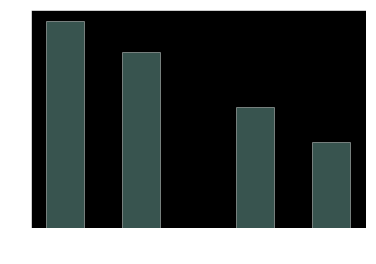

In [48]:
#Historgram of drug-drug interaction Management code:
plt.figure()
plt.style.use('dark_background')
sns.distplot(dd_compiled_art['Management_Code'],kde=False)
plt.show()

### Extracting side-effect data for a user-inputted HIV/ART drug

### ARTChat Version 1.0 Output Channel : 
#### Provides 1 component recommendation
> Here are 5 functions that go into the recommendation framework

In [54]:
def drugs_to_avoid(drug_name, side_effect_user):
    '''
    Identify the drugs to avoid based on the side-effect frequency
    '''
    print('------------------------DRUGS TO AVOID--------------------------')
    #1. Finding the location of the drug taken in the HIV/ART database
    drug_taken = drugs_art.loc[drugs_art['Brand_Names'].str.lower() ==
                               drug_user.lower()]

    #2. Checking if it is combination drug
    if drugs_art['Drug_Class'][drug_taken.index[0]] == 'Comb':
        print('Your therapy is a cocktail of the following drugs:')
    else:
        print('The generic name of your drug is:')

    #3. Extracting the ingredients of the combination drugs
    ingr_list = drugs_art['Generic_Name/Other_Names'][drug_taken.index[0]]
    print(ingr_list)  #print statement

    #4. Which drug(s) contributes most to the side-effect in question
    freq_side_effect_user = np.zeros(len(ingr_list))
    for i in np.arange(0, len(ingr_list) - 1):

        #5. First check if the drug is represented in the side-effect database:
        if ((ingr_list[i] in reduced_list.index) == True):
            freq_side_effect_user[i] = reduced_list.loc[ingr_list[i],
                                                  side_effect_user]
        else:
            freq_side_effect_user[
                i] = np.nan  #if the drug doesn't exit in the side-effect database
            #assign NaN to the frequency
            print('{0} does not exist in the SIDER database'.format(
                ingr_list[i]))

    #6. Which drugs contribute most of these side-effects? We will avoid them in the next regimen
    max_freq = np.nanmax(freq_side_effect_user)

    ingr_list = np.asarray(ingr_list)  #converting ingr_list to numpy array
    drugs_avoid = ingr_list[np.where(freq_side_effect_user == max_freq)]

    print(
        'The drug(s) that contribute(s) most to your {0} side-effect is(are): {1}'
        .format(side_effect_user, drugs_avoid))
    return(drugs_avoid)


def cluster_identifier(drug_name, rank):
    '''
    Identifies the cluster based on rank requested and returns drugs in the cluster
    '''
    #Step 1: Finding clusters that the undesirable drugs are seated in
    print('------------------------CLUSTER IDENTIFIER--------------------------')
    cluster_nos=[]
    cluster_desired_all=[]
    for i in np.arange(0,len(drug_name)):

        index = cluster_results.loc[cluster_results['Drug'].str.lower() == drug_name[i].lower()]
        
        cluster_no = index['Cluster_no'].values  #gives you cluster number of the drug
        print(cluster_no)
        cluster_no = cluster_no[0]  #collapses numpy array to a number for ease in indexing
        cluster_nos.append(cluster_no) #cluster numbers
                
        #Step 2: Find the cluster at the nth (rank) largest distance
        loc_array = heapq.nlargest(3,range(len(ranks_dist[cluster_no])), key=ranks_dist[cluster_no].__getitem__)
        #above: list of farthest to closest cluster
        cluster_desired = loc_array[rank]
        cluster_desired_all.append(cluster_desired)
    
    #Step 3: Make sure cluster_desired_all has no values from cluster_nos
    cluster_desired_shaved=[]
    for i in np.arange(0,len(cluster_desired_all)):
        if cluster_desired_all[i] not in cluster_nos:
            cluster_desired_shaved.append(cluster_desired_all[i])
        
    #Step 4: Make cluster_desired_shaved into a Series
    cluster_desired_shaved = pd.DataFrame({'desired_cluster':cluster_desired_shaved})
    
    #Step 5: Find the drugs within these desired clusters
    index_dr = pd.merge(left=cluster_results,right=cluster_desired_shaved,left_on='Cluster_no',right_on='desired_cluster')    
    
    return(index_dr['Drug']) #returns a pandas Series
    

def frequency_check(possible_drugs_1,side_effect):
    '''
    This function reduces a list of drug to ones where frequency of undesirable sideeffects < 50%
    '''
    #possible_drugs_1 = possible_drugs_1.tolist() #convert the drug series to a list
    
    drug_frequency_option = reduced_list.loc[possible_drugs_1,side_effect] #
    possible_drugs_2 = drug_frequency_option[drug_frequency_option.values < 50.00]
    return(possible_drugs_2.index)
    
def interaction_checker(drugs_recommended,coadmin_drug_user):

    string_1 = drugs_recommended['Drug'].tolist() #list of drugs that match a frequency criterion
    #string_1 = drugs_recommended
    #Cleaning up columns in Compiled ART and their drug-drug interaction database
    dd_compiled_art['Generic_Name/Other_Names'] = [str(i).replace('[', '').replace(']', '') for i in dd_compiled_art['Generic_Name/Other_Names']]
    dd_compiled_art['Generic_Name/Other_Names'] = [str(i).replace("\'", '') for i in dd_compiled_art['Generic_Name/Other_Names']]

    #Identifying ARTs that interact
    interactions_only = dd_compiled_art.loc[(dd_compiled_art['Generic_Name/Other_Names'].isin(string_1)) & dd_compiled_art['Interacting_Drug'].isin(coadmin_drug_user) & (dd_compiled_art['Management_Code'] == 3.0)]

    to_drop = interactions_only['Generic_Name/Other_Names']
    to_drop_name = to_drop.values.tolist()
    for i in np.arange(0,len(to_drop_name)):
        drugs_recommended = drugs_recommended[drugs_recommended.Drug != to_drop_name[i]]

    return(drugs_recommended) 

def class_check(possible_drugs_2): 
    '''
    returns a confidence value, if desired combination of 2 NRTIs and 1 PI/Insti is achieved
    '''
    #Step 1: Create a dataframe with drugs & their labels 
    drugs_copy = copy.deepcopy(drugs_art)
    drugs_copy['Generic_Name/Other_Names'] = [str(i).replace('[', '').replace(']', '') for i in drugs_copy['Generic_Name/Other_Names']]
    drugs_copy['Generic_Name/Other_Names'] = [str(i).replace("\'", '') for i in drugs_copy['Generic_Name/Other_Names']]
    drugs_labeled = drugs_copy.loc[(drugs_copy['Generic_Name/Other_Names'].isin(possible_drugs_2['Drug'].tolist()))]
    
    return(drugs_labeled)

def combination_recommender(drugs_recommended_final):
    a = drugs_art.groupby('Drug_Class')
    comb_df = a.get_group('Comb').reset_index() 
    comb_rec = []
    for i in np.arange(0,len(comb_df)):
        check = len(comb_df.loc[i]['Generic_Name/Other_Names']) #number of components in each combination    
        truth = drugs_recommended_final['Generic_Name/Other_Names'].isin(comb_df.loc[i]['Generic_Name/Other_Names'])
        check_i = np.sum(truth.values) #number of trues
        if check == check_i:
            comb_rec.append(comb_df.loc[i]['Brand_Names'])
    return(comb_rec)
    

### Function to check if the a drug has an interaction with another drug:

In [55]:
drug_user = 'Genvoya'
coadmin_drug_user = 'Amiodarone'
side_effect_user = 'Asthenia,Gastrointestinal pain'

#If the user inputs one drug and multiple side-effects
#drug_user = str(input('What HIV/ART drug or drugs are you taking?')) #Loop this incase of multiple drugs
#side_effect_user = str(input('What side-effect are you experiencing?'))
#coadmin_drug_user = str(input('What drug are you co-administering?'))
side_effect_user = side_effect_user.split(',') #useful if you have multiple inputs and for single inputs it makes it a list
coadmin_drug_user = coadmin_drug_user.split(',')
print(side_effect_user)
#Step 1: Culprit Identification:
drugs_avoid_all=[]

for i in np.arange(0,len(side_effect_user)):
    drugs_avoid = drugs_to_avoid(drug_name = drug_user, side_effect_user = side_effect_user[i])
    drugs_avoid = drugs_avoid.tolist()
    drugs_avoid_all.append(drugs_avoid) #appends all drugs to avoid

drugs_avoid_all = [item for sublist in drugs_avoid_all for item in sublist]
print(drugs_avoid_all)
drugs_avoid_all = list(dict.fromkeys(drugs_avoid_all))
print(drugs_avoid_all)

print('List of drugs to avoid based on contribution to side-effects are {0}'.format(drugs_avoid_all))

rank_1 = 0
count_nrti = 0
count_ii = 0
count_pi = 0

drugs_recommended_final = pd.DataFrame(columns=['Brand_Names','Generic_Name/Other_Names','Drug_Class'])

loop_end = 0
while((loop_end != 1) & (rank_1 < 3)):
    
    #Step 2: Cluster Identification:
    drugs_1 = cluster_identifier(drug_name = drugs_avoid_all, rank = rank_1) #returns drugs in the ranked cluster
    print('Drugs in clusters at rank {0} are {1}'.format(rank_1,drugs_1))
    
    
    #Step 3: Frequency Check
    drugs_2 = copy.deepcopy(drugs_1)
    for i in np.arange(len(side_effect_user)): #Going through each side-effect
        drugs_1 = copy.deepcopy(drugs_2)
        drugs_2 = frequency_check(possible_drugs_1 = drugs_1, side_effect = side_effect_user[i])
                  #for each side-effect returning only the drugs that have side-effect % <50%
        drugs_2 = drugs_2.tolist()
    
    drugs_2 = pd.DataFrame({'Drug':drugs_2})#input for interaction checker is a dataframe
    
    #Step 4: Ensuring the drugs don't interact with anything else
    drugs_25 = interaction_checker(drugs_recommended = drugs_2,coadmin_drug_user = coadmin_drug_user)

    #Step 5: What are the different classes of the drugs?
    drugs_3 = class_check(possible_drugs_2 = drugs_25) #input is a dataframe of drugs
    
    drugs_3 = drugs_3.drop_duplicates('Generic_Name/Other_Names') #drop duplicate values

    #Step 6: Confidence value
    count_nrti = count_nrti + len(drugs_3[drugs_3['Drug_Class'] == 'NRTI']) #can double count if it goes to the same cluster twice
    count_ii   = count_ii   + len(drugs_3[drugs_3['Drug_Class'] == 'INSTI'])
    count_pi   = count_pi   + len(drugs_3[drugs_3['Drug_Class'] == 'PI'])
    
    if (count_nrti >= 2):
        if ((count_pi >= 1) | (count_ii >= 1)):
            loop_end = 1 #exit out of the loop 
    
    rank_1 +=1 #move to the next cluster    
    drugs_recommended_final = drugs_recommended_final.append(drugs_3)

combinations_final = combination_recommender(drugs_recommended_final)

if (len(combinations_final) == 0):
    output_combinations = 'No existing brands offer an appropriate combination based on your regimen & functionality of this app'
else:
    output_combinations = str(combinations_final)
        

print('We went to the {0} farthest cluster to find combinations'.format(rank_1-1))
print('All drugs recommended are:')
drugs_recommended_final = drugs_recommended_final.drop_duplicates('Generic_Name/Other_Names')
drugs_recommended_final

['Asthenia', 'Gastrointestinal pain']
------------------------DRUGS TO AVOID--------------------------
Your therapy is a cocktail of the following drugs:
['elvitegravir', 'cobicistat', 'emtricitabine', 'tenofovir']
The drug(s) that contribute(s) most to your Asthenia side-effect is(are): ['elvitegravir' 'cobicistat']
------------------------DRUGS TO AVOID--------------------------
Your therapy is a cocktail of the following drugs:
['elvitegravir', 'cobicistat', 'emtricitabine', 'tenofovir']
The drug(s) that contribute(s) most to your Gastrointestinal pain side-effect is(are): ['elvitegravir' 'cobicistat' 'emtricitabine']
['elvitegravir', 'cobicistat', 'elvitegravir', 'cobicistat', 'emtricitabine']
['elvitegravir', 'cobicistat', 'emtricitabine']
List of drugs to avoid based on contribution to side-effects are ['elvitegravir', 'cobicistat', 'emtricitabine']
------------------------CLUSTER IDENTIFIER--------------------------
[2]
[2]
[2]
Drugs in clusters at rank 0 are 0    saquinavir
1  

,Brand_Names,Generic_Name/Other_Names,Drug_Class
17,Fuzeon,enfuvirtide,FI
2,Epivir,lamivudine,NRTI
3,Viread,tenofovir,NRTI
4,Retrovir,zidovudine,NRTI
7,Intelence,etravirine,NNRTI
8,Viramune,nevirapine,NNRTI
10,Edurant,rilpivirine,NNRTI
12,Prezista,darunavir,PI
18,Selzentry,maraviroc,CCR5
19,Tivicay,dolutegravir,INSTI


In [381]:
print(output_combinations)    

['Dovato', 'Juluca', 'Cimduo', 'Combivir']


In [53]:
drugs_copy = copy.deepcopy(drugs_art)
drugs_copy['Generic_Name/Other_Names'] = [str(i).replace('[', '').replace(']', '') for i in drugs_copy['Generic_Name/Other_Names']]
drugs_copy['Generic_Name/Other_Names'] = [str(i).replace("\'", '') for i in drugs_copy['Generic_Name/Other_Names']]
drugs_copy = drugs_copy.loc[(drugs_copy['Generic_Name/Other_Names'].isin(drugs_25['Drug'].tolist()))]

The code to deploy this prescription recommender as an app is laid out separately. Please email manan.kocher@gmail.com incase of any questions.